# Met Office Aircraft Data Exploration

---

In this notebook, aircraft data is taken from the CEDA data archive programmatically. The sources of this data are: the FAAM repository and the repository of the Meteorological Research Flight (MRF) facility. MRF data is held in the Nasa Ames format, and the chosen FAAM data that is downloaded will be netCDF. The data is explored by the means of some basic visualizations

### Prerequisites
The most important prerequisite to this tutorial is to generate a certificate from the CEDA website and shell script using your CEDA account. CEDA provides a [guide](https://help.ceda.ac.uk/article/4442-ceda-opendap-scripted-interactions) for certificate generation, the file-path for the generated certificate must be set in the environment variable below.
## Contents
- netCDF
    - Scrape CEDA
        - download the links
    - Explore the downloaded data
- Nasa Ames
    - Download as before
    - Explore
-
-

In [1]:
import iris
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

from bs4 import BeautifulSoup
import requests
import os
import sys

import pandas as pd

import cartopy.crs as ccrs

# clear cell outputs when private information is displayed
from IPython.display import clear_output
HIDE_SECRET_OUTPUT = True

In [2]:
# read environment file
env_vars = {}

with open(".env") as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [3]:
# load environment variables
CERT_SECRET = env_vars["CEDA_CERTIFICATE_DIRECTORY"]

### Scraping a CEDA repository

Scraping is the process of extracting data from websites, this is typically done in an automatic way with a "web crawler". Below a web crawler for a specified repository is defined.

The key tools to perform this crawl are: a [Recursive](https://en.wikipedia.org/wiki/Recursion_%28computer_science%29) implementation of [Depth-First-Search](https://en.wikipedia.org/wiki/Depth-first_search), html parser [Beautiful Soup](https://beautiful-soup-4.readthedocs.io/en/latest/), permission to search the repository (using the CEDA generated certificate), and some knowledge about the setup of the repository.

The result of this web crawl will be the links for all of the 1hz netCDF files in the FAAM data repository. the FAAM data repository has many different file extensions for the data: \[.zip, .txt, .html, .pdf, .kml, .ict, .dat, .xls, .ps, .na, and .nc\] . There also exist categories of data sorted into directories, e.g. directories with 'raw' in the name have not gone through any processing, so are ignored as this data is likely to be hard to handle. All forms of undesired data are ignored in the crawl, going down directories and pulling only the files specifically named after the 1hz data format. The 1hz data format is arguably the easiest data to handle.

In [4]:
cert_dir = CERT_SECRET # certificate file location generated by https://help.ceda.ac.uk/article/4442-ceda-opendap-scripted-interactions
visited_urls = set() # global sets to allow access in functions during recursion
download_links = set()
start_data_dir = './data/aircraft_data/netcdf_example' # root directory for downloaded content

def crawl_directory(url, start_data_dir):
    if url in visited_urls:
        return
    
    visited_urls.add(url)
    
    response = requests.get(url, cert=(cert_dir))
    
    soup = BeautifulSoup(response.content, 'html.parser') # parse the content, returns soup object
    
    if soup is None: # if nothing is found in the htmlparse, end
        return
    
#     os.makedirs(os.path.dirname(start_data_dir), exist_ok=True) # CREATE A NEW DIRECTORY/subdirectory in the download folder FOR EACH DIRECTORY ONLINE
    
#     with open(os.path.join(start_data_dir, 'page.html'), "w", errors='ignore') as f:   # WRITE THE CONTENTS OF THE DIRECTORY IN THE DIRECTORY WITH A PAGE.HTML FILE FOR NAVIGATION
#         f.write(str(soup))                                                             # (does not work without previous os.makdirs in most cases)
    
    for link in soup.find_all('a'):#hrefs exist in anchor elements
        if link.has_attr('href'):
            href = link['href'] #only explore links
        else:
            continue
        
        if(
            href == '../' 
        ): # don't go up in directories
            continue
        elif(href.endswith('/')): # if the link is a further directory
            if(
                'non' in href
                or href=='core_processed_standard/'
                or href=='core_processed_cloud_physics/'
                or 'temp' in href
                or 'raw' in href
                or 'video' in href
            ): # ignore known undesirable directories in our specific use-case
                continue
            if(len(href)==5): # print hrefs that are years just for easy progress tracking
                print("Looking in year:", href)
                if href == '2004/' or href == '2005/' or href == '2006/': #doesn't contain any desired files
                    continue
            # look in the directory
            crawl_directory(os.path.join(url, href), os.path.join(start_data_dir, href))
        elif(href.endswith('1hz.nc')): # save diserable files
            
            #don't download if there is a more recent version
            all_links = soup.find_all('a')
            all_hrefs = list([ link['href'] for link in all_links ])
            all_1hz = [desired_nc_file for desired_nc_file in all_hrefs if '1hz.nc' in desired_nc_file]
            # add all the 1hz files in this directory to the visited urls section (duplicates current href, but doesn't cause issue)
            for nc_1hz in all_1hz:
                visited_urls.add(os.path.join(url, nc_1hz))
            #add only the most recent revision to links that are kept
            all_1hz = sorted(all_1hz)
            most_recent_1hz = all_1hz[-1]
            download_links.add(os.path.join(url, most_recent_1hz)) # if chosen to mirror the directory setup as is online, good idea to just download the file instead of save download link
    
file_start_url = 'https://dap.ceda.ac.uk/badc/faam/data'
print('starting crawl')
crawl_directory(file_start_url, start_data_dir)
print('crawl end')
#convert 1hz.nc set to sorted list (sorts by year, then alphabetically on ?flightcode?)
download_links = sorted(list(download_links), reverse=True) # reverse to make recent data appear first in the list

# print(download_links)
print(len(download_links), "files found.")

starting crawl
Looking in year: 2004/
Looking in year: 2005/
Looking in year: 2006/
Looking in year: 2007/
Looking in year: 2008/
Looking in year: 2009/
Looking in year: 2010/
Looking in year: 2011/
Looking in year: 2012/
Looking in year: 2013/
Looking in year: 2014/
Looking in year: 2015/
Looking in year: 2016/
Looking in year: 2017/
Looking in year: 2018/
Looking in year: 2019/
Looking in year: 2020/
Looking in year: 2021/
Looking in year: 2022/
crawl end
1024 files found.


Now all of the links in the repository have been found, lets display the first and last entries of the data

In [5]:
print(download_links[:1]) # ':' not necessary when showing only 1 list item
print(download_links[-1:])

['https://dap.ceda.ac.uk/badc/faam/data/2022/c315-aug-08/core_processed/core_faam_20220808_v005_r0_c315_1hz.nc']
['https://dap.ceda.ac.uk/badc/faam/data/2007/b285-apr-19/core_processed/core_faam_20070419_v001_r0_b285_1hz.nc']


With the links found, download a portion of them for exploration:

In [6]:
#create directory to store data
save_dir = start_data_dir + '/'
os.makedirs(os.path.dirname(save_dir), exist_ok=True)
progress_check_number = 25 # if breaking on initial downloads, will download this many files

In [7]:
progress_counter = 0
BREAK_ON_INITIAL_DOWNLOADS = True #Don't download a tonne of data, might destroy directory space, choose better disk otherwise
for hzfile in download_links:
    if progress_counter % progress_check_number == 0:
        print("Downloaded number of files:", progress_counter)
        if BREAK_ON_INITIAL_DOWNLOADS:
            if progress_counter > 0:
                break
    nc_file_name = hzfile.split('/')[-1]
    save_hzfile_path = f"{save_dir}{nc_file_name}"
    if not os.path.exists(save_hzfile_path): # don't download files if already exist on disk
        response = requests.get(hzfile, cert=(CERT_SECRET))
        response_content = response.content
        if response.status_code != 200:
            print(response_content)
            print("\n!!!Exception, likely the certificate is not valid! response above!!!\n")
            raise Exception()
        with open(save_hzfile_path, 'wb') as f:
            f.write(response_content)
    progress_counter+=1

Downloaded number of files: 0
Downloaded number of files: 25


In [8]:
# take the most recent file
all_saved_files_pattern = save_dir + '*'
saved_files_most_recent_first = sorted(glob.glob(all_saved_files_pattern), reverse=True)
most_recent_file = saved_files_most_recent_first[8]

In [9]:
cubes = iris.load(most_recent_file)

In [10]:
ds = xr.open_dataset(most_recent_file)
ds

<xarray.Dataset>
Dimensions:              (Time: 23969)
Coordinates:
  * Time                 (Time) datetime64[ns] 2022-07-30T13:24:31 ... 2022-0...
    LAT_GIN              (Time) float32 ...
    LON_GIN              (Time) float32 ...
Data variables: (12/178)
    P10_STAT             (Time) float32 ...
    P10_STAT_FLAG        (Time) float32 ...
    EXX_JCI              (Time) float32 ...
    EXX_JCI_FLAG         (Time) float32 ...
    LAT_GIN_FLAG         (Time) float32 ...
    LON_GIN_FLAG         (Time) float32 ...
    ...                   ...
    SEA_TWC_083          (Time) float32 ...
    SEA_TWC_083_FLAG     (Time) float32 ...
    SEA_LWC_021          (Time) float32 ...
    SEA_LWC_021_FLAG     (Time) float32 ...
    SEA_LWC_083          (Time) float32 ...
    SEA_LWC_083_FLAG     (Time) float32 ...
Attributes: (12/60)
    Conventions:                           CF-1.9 ACDD-1.3
    acknowledgement:                       Airborne data was obtained using t...
    comment:                               DCMEX science flight around Langmu...
    constants_file:                        flight-cst_faam_20220730_r0_c307.yaml
    creator_address:                       Building 146, Cranfield University...
    creator_email:                         info@faam.ac.uk
    ...                                    ...
    summary:                               Data gathered during flight c307 o...
    time_coverage_duration:                PT6H39M28S
    time_coverage_end:                     2022-07-30T20:03:59Z
    time_coverage_start:                   2022-07-30T13:24:31Z
    title:                                 FAAM core data from c307
    uuid:                                  acc0f0d5-6c96-3209-88fe-8b5501d9c1af

Text(0.5, 0.92, 'Reported lon, lat, altitude data from flight path')

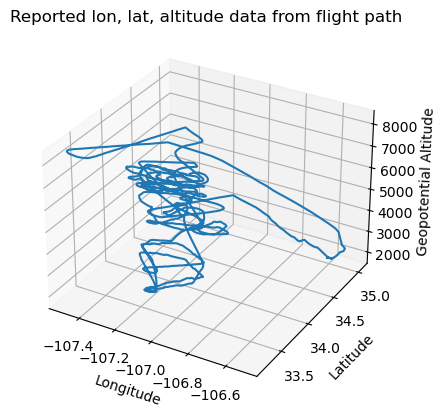

In [11]:
alt_vals = ds['ALT_GIN']
lat_vals = ds['LAT_GIN']
lon_vals = ds['LON_GIN']
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(lon_vals, lat_vals, alt_vals)
ax.scatter(lon_vals[0], lat_vals[0], alt_vals[0], c='Green', label='Start')
ax.scatter(lon_vals[-1], lat_vals[-1], alt_vals[-1], c='Red', label='Stop')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Geopotential Altitude')
plt.title('Reported lon, lat, altitude data from flight path')

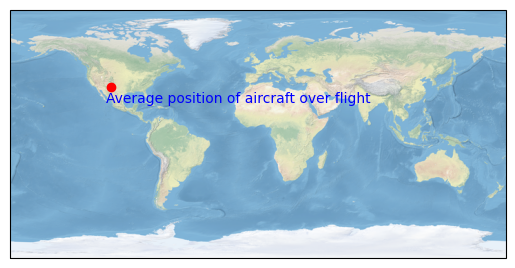

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

average_lon, average_lat = np.mean(lon_vals), np.mean(lat_vals)
plt.scatter(average_lon, average_lat, transform=ccrs.Geodetic(), c='r')
plt.text(
    average_lon - 3, average_lat - 12, 'Average position of aircraft over flight',
    horizontalalignment='left',
    transform=ccrs.Geodetic(),
    c='blue'
)

plt.show()

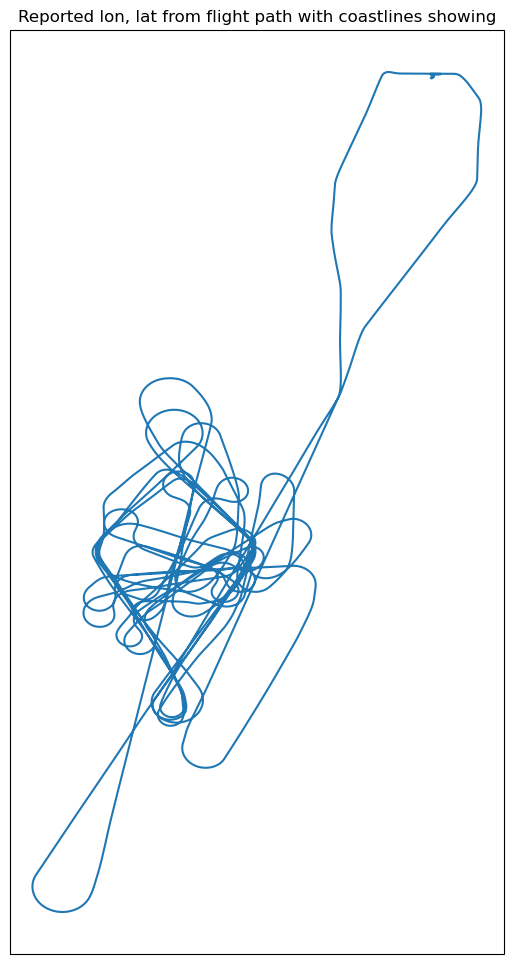

In [13]:
import cartopy.crs as ccrs
proj = ccrs.PlateCarree()  # cartopy projection
fig = plt.figure(figsize=(12, 12))  # size of plot
axes = plt.axes(projection=proj)  # plot transform
ax = plt.plot(lon_vals, lat_vals, transform=ccrs.PlateCarree())
plt.title('Reported lon, lat from flight path with coastlines showing')
axes.coastlines()  # show maplines

### Exploration of Nasa Ames formatted aircraft data (MRF)

As before, we will download data from CEDA programmatically, however in this case, there are a lot more caveats as the data is held in a lesser standard. At some point in the data, the parameter name is given in the file extension, the majority of the files are Nasa Ames, but are given sometimes as .dat .out in addition to '.na'.   The Nasa Ames format 

In [14]:
visited_urls_ames = set() # global sets to allow access in functions during recursion
download_links_ames = set()
start_data_dir_ames = './data/aircraft_data/nasa-ames_example' # root directory for downloaded content
all_files = set()

def crawl_directory_ames(url, start_data_dir):
    if url in visited_urls_ames:
        return
    
    visited_urls_ames.add(url)
    
    response = requests.get(url, cert=(cert_dir))
    
    soup = BeautifulSoup(response.content, 'html.parser') # parse the content, returns soup object
    
    if soup is None: # if nothing is found in the htmlparse, end
        return
    
    for link in soup.find_all('a'):#hrefs exist in anchor elements
        if link.has_attr('href'):
            href = link['href'] #only explore links
        else:
            continue
        if(
            href == '../' 
        ): # don't go up in directories
            continue
            # look in the directory
        elif(href.endswith('/')):
            print('found dir:', href)
            crawl_directory_ames(os.path.join(url, href), os.path.join(start_data_dir, href))
        elif(href.endswith('.na')): # save diserable files
            download_links_ames.add(os.path.join(url, href)) # if chosen to mirror the directory setup as is online, good idea to just download the file instead of save download link
        else:
            if '.' in href:
                all_files.add(href) # add uncaught file, out of interest in generating all the different file extensions
    
file_start_url_ames = 'https://dap.ceda.ac.uk/badc/ukmo-mrf/data'
print('starting crawl')
crawl_directory_ames(file_start_url_ames, start_data_dir_ames)
print('crawl end')
#convert 1hz.nc set to sorted list (sorts by year, then alphabetically on ?flightcode?)
download_links_ames = sorted(list(download_links_ames), reverse=True) # reverse to make recent data appear first in the list

# print(download_links)
print(len(download_links_ames), "files found.")
map_get_file_extension = lambda x: x[x.rfind('.'):]
file_exts = map(map_get_file_extension, all_files)
print("\nAll file extensions excluding .na (and files without extension):\n", sorted(list(set(file_exts)))) # set to remove duplicates, then sorted list

starting crawl
found dir: a254/
found dir: a257/
found dir: a258/
found dir: a259/
found dir: a260/
found dir: a297/
found dir: a298/
found dir: a308/
found dir: a309/
found dir: a311/
found dir: a312/
found dir: a313/
found dir: a318/
found dir: a319/
found dir: a320/
found dir: a330/
found dir: a331/
found dir: a360/
found dir: a400/
found dir: a431/
found dir: a444/
found dir: a445/
found dir: a475/
found dir: a476/
found dir: a477/
found dir: a478/
found dir: a479/
found dir: a480/
found dir: a481/
found dir: a512/
found dir: a531/
found dir: a532/
found dir: a533/
found dir: a534/
found dir: a536/
found dir: a574/
found dir: a575/
found dir: a576/
found dir: a577/
found dir: a578/
found dir: a579/
found dir: a580/
found dir: a581/
found dir: a584/
found dir: a646/
found dir: flightfolder/
found dir: a647/
found dir: flightfolder/
found dir: a658/
found dir: flightfolder/
found dir: a660/
found dir: flightfolder/
found dir: a661/
found dir: flightfolder/
found dir: a663/
found dir:

In [15]:
print(download_links_ames[0])
print(download_links_ames[-1])

https://dap.ceda.ac.uk/badc/ukmo-mrf/data/a782/he20000830_wnd.na
https://dap.ceda.ac.uk/badc/ukmo-mrf/data/a779/he20000825_clr.na


The result of the above cell allows for the assumption that the .na extension was chosen to be used for the nasa ames files in 4 of the flights from 779-782.

next, one of these flights shall be selected for exploration.

In [16]:
# get only one flights worth of na data
most_recent_file_dir = download_links_ames[0][0:download_links_ames[0].rfind('/')]
most_recent_flight = most_recent_file_dir[most_recent_file_dir.rfind('/')+1:]
print("Taking flight:",most_recent_flight)
files_to_download = [most_recent_file for most_recent_file in download_links_ames if most_recent_flight in most_recent_file]
print(len(files_to_download), "files to download.")

ames_save_directory = './data/aircraft_data/nasa-ames_example/'

Taking flight: a782
30 files to download.


In [17]:
print("Starting download")
for ames_file in files_to_download:
    ames_file_name = ames_file.split('/')[-1]
    ames_file_name = most_recent_flight + '_' + ames_file_name
    ames_filepath = f"{ames_save_directory}{ames_file_name}"
    if not os.path.exists(ames_filepath): # don't download files if already exist on disk
        response = requests.get(ames_file, cert=(CERT_SECRET))
        response_content = response.content
        if response.status_code != 200:
            print(response_content)
            print("\n!!!Exception, likely the certificate is not valid! response above!!!\n")
            raise Exception()
        with open(ames_filepath, 'wb') as f:
            f.write(response_content)
print('download end')

Starting download
download end


In [18]:
# get the downloaded na files to a list
ames_file_pattern_str = ames_save_directory + most_recent_flight +'*.na'
na_files_to_load = glob.glob(ames_file_pattern_str)

In [19]:
# settings for fileread
time_variable_index_from_inspection = 8

In [21]:
%%time
# load
global_time_name = None
df_list = []
for na_file in na_files_to_load:
    print("Start file:", na_file)
    data_list = []
    with open(na_file) as f:
        file_lines = f.readlines()
        variable_end_index = None
        for i in range(12,len(file_lines)):
            try:
                int(file_lines[i])
                variable_end_index = i
                break
            except:
                continue
        data_categories = file_lines[12:variable_end_index]
        header_line_count = int(file_lines[0].split(' ')[0])
        data_lines = file_lines[header_line_count:]
        for line in data_lines:
            separated_data = line.split()
            data_list.append(separated_data)
    df=pd.DataFrame(data_list)
    
    
    data_column_names = list(map(str.strip, data_categories))
    if global_time_name is None:
        global_time_name = file_lines[time_variable_index_from_inspection]
        global_time_name = "".join(global_time_name.split()) # sometimes the whitespace of the read line is different, ensure consistency
        print("Updated time variable:", global_time_name)
    time_variable = [global_time_name]
    data_column_names = time_variable + data_column_names
    df.columns = data_column_names
    df['File_Name'] = na_file
    df_list.append(df)

Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_wnd.na
Updated time variable: ElapsedUTsfrom0hrson20000830
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_tw1.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_tmp.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_sil.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_red.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_rad.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ps1.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ge1.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds022.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds021.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds020.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds019.na
Start file: ./data/aircraft_data/nasa-ames_example/a

In [22]:
%%time
large_df = pd.concat(df_list)
large_df[global_time_name] = pd.to_numeric(large_df[global_time_name])
large_df = large_df.sort_values(global_time_name)
large_df = large_df.reset_index()
large_df

CPU times: user 8.1 s, sys: 5.88 s, total: 14 s
Wall time: 19.9 s


,index,ElapsedUTsfrom0hrson20000830,NORTHWARD WIND COMPT(M S-1 ),ERROR FLAG (NORTHWARD WIND COMPT),EASTWARD WIND COMPT (M S-1 ),ERROR FLAG (EASTWARD WIND COMPT ),VERTICAL WIND COMPT(M S-1 ),ERROR FLAG (VERTICAL WIND COMPT),File_Name,TOTAL WATER CONTENT (G KG-1 ),...,Geopotential altitude(m),error flag (Geopotential altitude),no. of satellites in GPS wind,error flag (no. of satellites in GPS wind),no. of satellites tracked by sonde,error flag (no. of satellites tracked by sonde),CORR UPPER CLR FLUX (W M-2 ),ERROR FLAG (CORR UPPER CLR FLUX ),CORR LOWER CLR FLUX (W M-2 ),ERROR FLAG (CORR LOWER CLR FLUX )
0,0,36300.000000,1.67041016,0,5.32446289,0,-1.37353516,0,./data/aircraft_data/nasa-ames_example/a782_he...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...,13.9175529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801507,1286461,56400.953125,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...,999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2801508,643231,56400.968750,-6.19555664,0,-2.83471680,0,0.263916016,0,./data/aircraft_data/nasa-ames_example/a782_he...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2801509,1286462,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...,999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2801510,643231,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
print(large_df.columns)

Index(['index', 'ElapsedUTsfrom0hrson20000830',
       'NORTHWARD WIND COMPT(M S-1   )', 'ERROR FLAG (NORTHWARD WIND COMPT)',
       'EASTWARD WIND COMPT (M S-1   )', 'ERROR FLAG (EASTWARD WIND COMPT )',
       'VERTICAL  WIND COMPT(M S-1   )', 'ERROR FLAG (VERTICAL  WIND COMPT)',
       'File_Name', 'TOTAL WATER CONTENT (G KG-1  )',
       'ERROR FLAG (TOTAL WATER CONTENT )', 'STATIC PRESSURE     (MB      )',
       'ERROR FLAG (STATIC PRESSURE     )', 'DEICED TRUE TEMP    (DEG K   )',
       'ERROR FLAG (DEICED TRUE TEMP    )', 'NON-DEICED TRUE TEMP(DEG K   )',
       'ERROR FLAG (NON-DEICED TRUE TEMP)', 'CORR UPPER I/R FLUX (W M-2   )',
       'ERROR FLAG (CORR UPPER I/R FLUX )', 'CORR LOWER I/R FLUX (W M-2   )',
       'ERROR FLAG (CORR LOWER I/R FLUX )', 'CORR UPPER RED FLUX (W M-2   )',
       'ERROR FLAG (CORR UPPER RED FLUX )', 'CORR LOWER RED FLUX (W M-2   )',
       'ERROR FLAG (CORR LOWER RED FLUX )', 'RADAR HEIGHT        (METRES  )',
       'ERROR FLAG (RADAR HEIGHT        

In [27]:
position_cols = [
    global_time_name, 
    'gps longitude(deg)', 'error flag   (gps longitude)', 
    'GPS latitude(deg)', 'error flag   (GPS latitude)', 
    'Geopotential altitude(m)', 'error flag   (Geopotential altitude)'
]
plane_pos = large_df[position_cols]
plane_pos

,ElapsedUTsfrom0hrson20000830,gps longitude(deg),error flag (gps longitude),GPS latitude(deg),error flag (GPS latitude),Geopotential altitude(m),error flag (Geopotential altitude)
0,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2801507,56400.953125,NaN,NaN,NaN,NaN,NaN,NaN
2801508,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN
2801509,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN
2801510,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# set the bad data to NaN
error_flag_var_boolean = plane_pos.columns.str.contains('error flag')
df_error_flags = plane_pos.loc[:, error_flag_var_boolean]
good_data_mask = ((df_error_flags=='2') | (df_error_flags=='3'))
flag_to_data = np.concatenate((error_flag_var_boolean[1:], [False]))
df_data = plane_pos.loc[:, flag_to_data]
df_data.apply(pd.to_numeric)
good_data_mask.columns = df_data.columns
nan_df = df_data.mask(good_data_mask, other=np.NaN)
nan_cols = nan_df.columns
plane_pos = plane_pos.copy()
plane_pos.loc[:,nan_cols] = nan_df
plane_pos

,ElapsedUTsfrom0hrson20000830,gps longitude(deg),error flag (gps longitude),GPS latitude(deg),error flag (GPS latitude),Geopotential altitude(m),error flag (Geopotential altitude)
0,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2801507,56400.953125,NaN,NaN,NaN,NaN,NaN,NaN
2801508,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN
2801509,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN
2801510,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# if all of the values are NaN, drop the data
values_on_a_col = plane_pos['Geopotential altitude(m)'].notna() | plane_pos['GPS latitude(deg)'].notna() | plane_pos['gps longitude(deg)'].notna()
plane_pos = plane_pos[values_on_a_col]
plane_pos

,ElapsedUTsfrom0hrson20000830,gps longitude(deg),error flag (gps longitude),GPS latitude(deg),error flag (GPS latitude),Geopotential altitude(m),error flag (Geopotential altitude)
267518,38238.5,NaN,3,NaN,3,1372.76,0
267587,38239.0,NaN,3,NaN,3,1372.76,0
267657,38239.5,NaN,3,NaN,3,1373.04,0
267730,38240.0,NaN,3,NaN,3,1375.35,0
267797,38240.5,NaN,3,NaN,3,1375.01,0
...,...,...,...,...,...,...,...
2603170,54963.9,-20.86013,0,15.98305,0,NaN,3
2603242,54964.4,-20.86015,0,15.98303,0,NaN,3
2603310,54964.9,-20.86016,0,15.98301,0,NaN,3
2603382,54965.4,-20.86018,0,15.98300,0,NaN,3


In [30]:
# have a look to see if data is feasibly plotted where all three values exist
plane_pos_hard_constraint = plane_pos.dropna()
plane_pos_hard_constraint

,ElapsedUTsfrom0hrson20000830,gps longitude(deg),error flag (gps longitude),GPS latitude(deg),error flag (GPS latitude),Geopotential altitude(m),error flag (Geopotential altitude)
275143,38293.0,-0.00972,0,13.31455,0,5554.96,0
275217,38293.5,-0.01049,0,13.31521,0,5547.12,0
275288,38294.0,-0.01055,0,13.31521,0,5539.88,0
275358,38294.5,-0.01068,0,13.31529,0,5531.49,0
275431,38295.0,-0.01074,0,13.31529,0,5523.73,0
...,...,...,...,...,...,...,...
2601210,54949.9,-20.85970,0,15.98352,0,-272.58,0
2601282,54950.4,-20.85972,0,15.98351,0,-277.95,0
2601350,54950.9,-20.85973,0,15.98349,0,-283.86,0
2601422,54951.4,-20.85975,0,15.98347,0,-289.47,0


In [31]:
lon_vals = list(map(float, plane_pos_hard_constraint['gps longitude(deg)']))
lat_vals = list(map(float, plane_pos_hard_constraint['GPS latitude(deg)']))
alt_vals = list(map(float, plane_pos_hard_constraint['Geopotential altitude(m)']))

In [32]:
print(lon_vals[0:3], lat_vals[0:3], alt_vals[0:3])

[-0.00972, -0.01049, -0.01055] [13.31455, 13.31521, 13.31521] [5554.96, 5547.12, 5539.88]


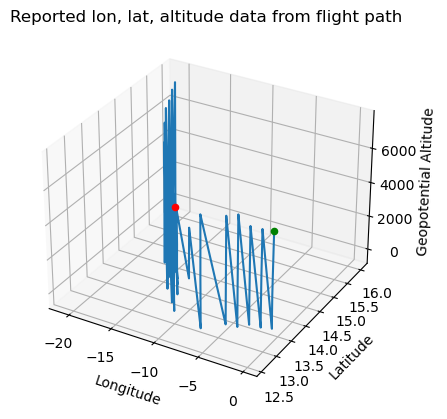

In [33]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(lon_vals, lat_vals, alt_vals)
ax.scatter(lon_vals[0], lat_vals[0], alt_vals[0], c='Green', label='Start')
ax.scatter(lon_vals[-1], lat_vals[-1], alt_vals[-1], c='Red', label='Stop')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Geopotential Altitude')
plt.title('Reported lon, lat, altitude data from flight path')

plt.show()

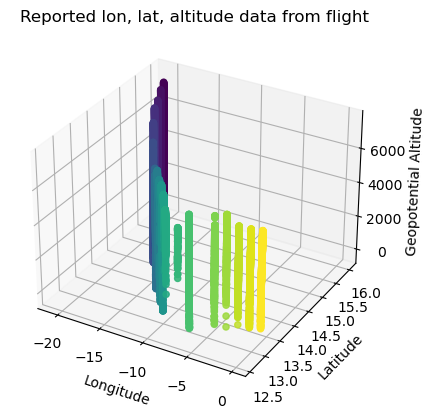

In [34]:
fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(lon_vals, lat_vals, alt_vals, c=lon_vals) # cary the color with the longitude
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_zlabel('Geopotential Altitude')
plt.title('Reported lon, lat, altitude data from flight')
plt.show()

---

## References

If material in the notebook was adapted from other source material for NOAA, link to it.

Also, add other material either cited in the text or that extends content in the notebook.

### Acknowledgements